# 3. Symulacja numeryczna - schemat niejawny

Celem symulacji jest rozwiązanie problemu początkowo-brzegowego zdefiniowanego przez układ równań (4)-(7).

**Równania ewolucji (4)-(5):**
$$
\begin{cases}
\frac{\partial u}{\partial t} = a - u - uv^2 + d_1 \Delta u \\
\frac{\partial v}{\partial t} = uv^2 - mv + d_2 \Delta v
\end{cases}
$$

**Warunki Brzegowe (6):**
$$
u(x, t) = v(x, t) = 0 \tag{6}
$$

**Warunki Początkowe (7):**
Symulację startujemy od stanu pustynnego z nałożonym małym losowym zaburzeniem (szumem) $\xi$:
$$
u(x, y, 0) = a, \quad v(x, y, 0) = \xi(x, y) \tag{7}
$$

### Metoda numeryczna i dyskretyzacja

Przestrzeń dyskretyzujemy metodą różnic skończonych na siatce $N \times N$. Operator Laplace'a $\Delta$ aproksymujemy standardowym schematem pięciopunktowym.

Stosujemy schemat niejawny z rozdzieleniem operatorów.

W każdym kroku czasowym $h_t$ obliczenia dzielimy na etapy:

1.  **Krok Reakcji (Nieliniowy):** Obliczamy zmianę wynikającą z lokalnej dynamiki $f(u, v)$ metodą jawną:
    $$u^* = u^n + h_t \cdot f(u^n, v^n)$$

2.  **Krok Dyfuzji:** Operator Laplace'a $\Delta$ rozbijamy na kierunki $X$ i $Y$. Zamiast rozwiązywać jedną dużą macierz $N^2 \times N^2$, rozwiązujemy naprzemiennie układy równań dla wierszy i kolumn:

    * Rozwiązujemy dyfuzję wzdłuż osi $x$.
        $$(I - \frac{h_t}{2} D \partial_{xx}) u^{**} = u^* + \frac{h_t}{2} D \partial_{yy} u^*$$
    * Rozwiązujemy dyfuzję wzdłuż osi $y$.
        $$(I - \frac{h_t}{2} D \partial_{yy}) u^{n+1} = u^{**} + \frac{h_t}{2} D \partial_{xx} u^{**}$$

Powyższe podejście sprowadza problem 2D do serii układów z macierzami trójdiagonalnymi, które rozwiązujemy za pomocą Algorytmu Thomasa.

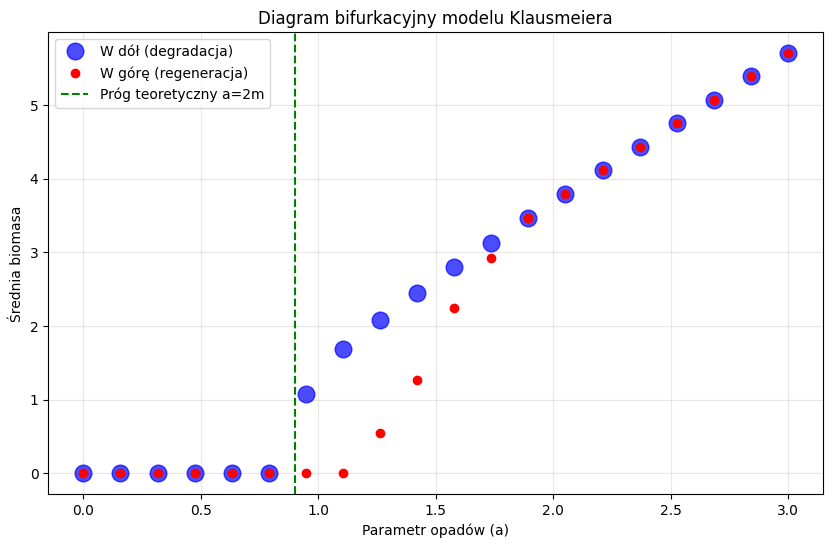

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time

N = 32           # siatka
T = 100
DT = 0.01        #krok
k = int(T / DT)  # liczba krokow
pkt_a = 20       # punkty dla a

# algorytm Thomasa
def solve_vectorized(a, b, c, d):
    n = d.shape[0]
    
    # zapisujemy same przekątne bo poza nimi są zera
    ac = a[:, np.newaxis]        # dolna przekątma
    bc = b[:, np.newaxis].copy() # glowna przekątna
    cc = c[:, np.newaxis]        # gorna przekątna
    dc = d                       # prawa strona rownania
    
    # eliminacja
    for i in range(1, n):
        m = ac[i-1] / bc[i-1]
        bc[i] = bc[i] - m * cc[i-1]
        dc[i] = dc[i] - m * dc[i-1]
        
    # podstawianie wsteczne
    x = np.zeros_like(dc)
    x[-1] = dc[-1] / bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x

class KlausmeierSolver:
    def __init__(self):
        self.d1 = 0.1; self.d2 = 0.01; self.m = 0.45
        
        # macierze
        mu_u = (self.d1 * DT) / 2.0 
        self.main_u = (1 + 2 * mu_u) * np.ones(N) 
        self.main_u[0]=1; self.main_u[-1]=1
        self.off_u  = -mu_u * np.ones(N-1)       
        self.off_u[0]=0;  self.off_u[-1]=0

        mu_v = (self.d2 * DT) / 2.0
        self.main_v = (1 + 2 * mu_v) * np.ones(N) 
        self.main_v[0]=1; self.main_v[-1]=1
        self.off_v  = -mu_v * np.ones(N-1)        
        self.off_v[0]=0;  self.off_v[-1]=0

        self.U = np.zeros((N, N))
        self.V = np.zeros((N, N))
        self.a = 2.5

    def solve_step(self):
        u, v = self.U, self.V
        
        # limit
        u = np.clip(u, 0, 50); v = np.clip(v, 0, 50)
        
        uv2 = u * (v**2)
        du = self.a - u - uv2
        dv = uv2 - self.m * v
        u += du * DT
        v += dv * DT
        
        # Dirichlet
        u[0,:]=0; u[-1,:]=0
        u[:,0]=0; u[:,-1]=0
        v[0,:]=0; v[-1,:]=0
        v[:,0]=0; v[:,-1]=0

        # Y
        rhs_u = u + (self.d1 * DT / 2.0) * self.laplacian(u, 0)
        rhs_v = v + (self.d2 * DT / 2.0) * self.laplacian(v, 0)
        rhs_u[:,0]=0; rhs_u[:,-1]=0; rhs_v[:,0]=0; rhs_v[:,-1]=0
        u = solve_vectorized(self.off_u, self.main_u, self.off_u, rhs_u)
        v = solve_vectorized(self.off_v, self.main_v, self.off_v, rhs_v)

        # X
        rhs_u = u + (self.d1 * DT / 2.0) * self.laplacian(u, 1)
        rhs_v = v + (self.d2 * DT / 2.0) * self.laplacian(v, 1)
        rhs_u[0,:]=0; rhs_u[-1,:]=0; rhs_v[0,:]=0; rhs_v[-1,:]=0
        u = solve_vectorized(self.off_u, self.main_u, self.off_u, rhs_u.T).T
        v = solve_vectorized(self.off_v, self.main_v, self.off_v, rhs_v.T).T
        
        self.U, self.V = u, v

    def laplacian(self, arr, axis):
        res = np.zeros_like(arr)
        if axis == 0: 
            res[1:-1, :] = arr[:-2, :] - 2*arr[1:-1, :] + arr[2:, :]
        else:         
            res[:, 1:-1] = arr[:, :-2] - 2*arr[:, 1:-1] + arr[:, 2:]
        return res

start_time = time.time()

a_down = np.linspace(3.0, 0.0, pkt_a)
a_up   = np.linspace(0.0, 3.0, pkt_a)
full_path = np.concatenate([a_down, a_up])

results = []
colors = []

solver = KlausmeierSolver()
solver.a = full_path[0]
solver.U[:] = solver.a
solver.V[:] = 5.0

for i, a_val in enumerate(full_path):
    solver.a = a_val
    
    # powrót i nasiona
    if i >= pkt_a:
        colors.append('red')
        if np.mean(solver.V) < 0.1:
            solver.V += np.random.uniform(0, 0.5, (N, N))
    else:
        colors.append('blue')

    for _ in range(k):
        solver.solve_step()
        
    results.append(np.mean(solver.V))
    

results_down = results[:pkt_a]
results_up = results[pkt_a:]

plt.figure(figsize=(10, 6))
plt.plot(a_down, results_down, 'bo', markersize=12, alpha=0.7, label='W dół (degradacja)')
plt.plot(a_up, results_up, 'ro', markersize=6, label='W górę (regeneracja)')

plt.axvline(x=0.9, color='green', linestyle='--', label='Próg teoretyczny a=2m')
plt.title('Diagram bifurkacyjny modelu Klausmeiera')
plt.xlabel('Parametr opadów (a)')
plt.ylabel('Średnia biomasa')
plt.grid(True, alpha=0.3)
plt.legend()

plt.savefig('diagram_bifurkacji_final.png', dpi=300, bbox_inches='tight')

# zapisanie wartosci
data_down = np.column_stack((a_down, results_down))
data_up   = np.column_stack((a_up, results_up))

np.savetxt("wyniki_degradacja.csv", data_down, delimiter=",", header="a,biomasa", comments="")
np.savetxt("wyniki_regeneracja.csv", data_up, delimiter=",", header="a,biomasa", comments="")

plt.show()

**Diagram bifurkacyjny modelu Klausmeiera.**
Wykres przedstawia zależność średniej biomasy roślin ($v$) od parametru opadów ($a$). 
Kolorem niebieskim oznaczamy proces degradacji (start z pełnego zalesienia), gdzie nagłe załamanie ekosystemu następuje w okolicy progu teoretycznego $a \approx 0.9$. 
Kolorem czerwonym oznaczamy proces regeneracji (start z pustyni). Widoczna pętla histerezy wskazuje na zjawisko bistabilności – w zakresie $a \in (0.9, 1.4)$ możliwe jest współistnienie zarówno stanu wegetacji, jak i stanu pustynnego, zależnie od historii układu.

Obliczamy rozwiązanie referencyjne dla dt = 0.005
Testujemy większe kroki czasowe:
   dt = 0.200 -> Błąd = 5.925571
   dt = 0.100 -> Błąd = 0.000006
   dt = 0.050 -> Błąd = 0.000002
   dt = 0.020 -> Błąd = 0.000001
   dt = 0.010 -> Błąd = 0.000000


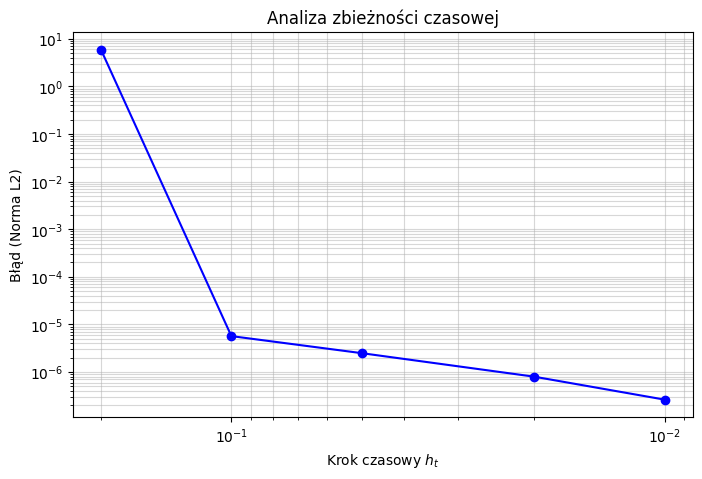

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import time

N_TEST = 32      
T_TEST = 10.0
SEEDS = 42

dt_values = [0.2, 0.1, 0.05, 0.02, 0.01] 
dt_ref = 0.005 

class KlausmeierErrorTest:
    def __init__(self, N=32, dt=0.01):
        self.N = N
        self.dt = dt
        self.d1 = 0.1; self.d2 = 0.01; self.m = 0.45; self.a = 2.0
        
        mu_u = (self.d1 * dt) / 2.0 
        self.md_u = (1 + 2 * mu_u) * np.ones(N)
        self.md_u[0]=1; self.md_u[-1]=1
        self.od_u = -mu_u * np.ones(N-1)
        self.od_u[0]=0;  self.od_u[-1]=0

        mu_v = (self.d2 * dt) / 2.0
        self.md_v = (1 + 2 * mu_v) * np.ones(N)
        self.md_v[0]=1; self.md_v[-1]=1
        self.od_v = -mu_v * np.ones(N-1)
        self.od_v[0]=0;  self.od_v[-1]=0

    def _solve_tdma(self, a, b, c, d):
        n = len(d); ac=a[:,None]; bc=b[:,None].copy(); cc=c[:,None]; dc=d
        for i in range(1, n):
            m = ac[i-1]/bc[i-1]; bc[i]-=m*cc[i-1]; dc[i]-=m*dc[i-1]
        x = np.zeros_like(dc); x[-1]=dc[-1]/bc[-1]
        for i in range(n-2,-1,-1): x[i]=(dc[i]-cc[i]*x[i+1])/bc[i]
        return x

    def _lap(self, arr, ax):
        res = np.zeros_like(arr)
        if ax==0: res[1:-1,:] = arr[:-2,:] - 2*arr[1:-1,:] + arr[2:,:]
        else:     res[:,1:-1] = arr[:,:-2] - 2*arr[:,1:-1] + arr[:,2:]
        return res

    def run(self, steps, seed):
        np.random.seed(seed)
        u = np.full((self.N, self.N), self.a) + np.random.uniform(-0.1, 0.1, (self.N, self.N))
        v = np.full((self.N, self.N), 2.0) + np.random.uniform(-0.1, 0.1, (self.N, self.N))
        
        for _ in range(steps):
            u=np.clip(u,0,50); v=np.clip(v,0,50)
            uv2 = u*(v**2)
            u += (self.a - u - uv2)*self.dt
            v += (uv2 - self.m*v)*self.dt
            u[0,:]=0; u[-1,:]=0; 
            u[:,0]=0; u[:,-1]=0
            v[0,:]=0; v[-1,:]=0
            v[:,0]=0; v[:,-1]=0

            ru = u + (self.d1*self.dt/2)*self._lap(u,0); rv = v + (self.d2*self.dt/2)*self._lap(v,0)
            ru[:,0]=0; ru[:,-1]=0; rv[:,0]=0; rv[:,-1]=0
            u = self._solve_tdma(self.od_u, self.md_u, self.od_u, ru)
            v = self._solve_tdma(self.od_v, self.md_v, self.od_v, rv)

            ru = u + (self.d1*self.dt/2)*self._lap(u,1); rv = v + (self.d2*self.dt/2)*self._lap(v,1)
            ru[0,:]=0; ru[-1,:]=0; rv[0,:]=0; rv[-1,:]=0
            u = self._solve_tdma(self.od_u, self.md_u, self.od_u, ru.T).T
            v = self._solve_tdma(self.od_v, self.md_v, self.od_v, rv.T).T
            
        return v

print("Obliczamy rozwiązanie referencyjne dla dt =", dt_ref)
ref_solver = KlausmeierErrorTest(N=N_TEST, dt=dt_ref)
ref_steps = int(T_TEST / dt_ref)
v_ref = ref_solver.run(ref_steps, SEEDS)

errors = []
print("Testujemy większe kroki czasowe:")
for dt in dt_values:
    solver = KlausmeierErrorTest(N=N_TEST, dt=dt)
    steps = int(T_TEST / dt)
    v_test = solver.run(steps, SEEDS)
    
    # obliczamy błąd (Norma L2 różnicy macierzy)
    # dzielimy przez N*N, żeby mieć średni błąd
    err = np.linalg.norm(v_test - v_ref) / (N_TEST * N_TEST)
    errors.append(err)
    print(f"   dt = {dt:.3f} -> Błąd = {err:.6f}")

plt.figure(figsize=(8, 5))
plt.plot(dt_values, errors, 'bo-', label='Błąd względem dt=0.005')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Krok czasowy $h_t$')
plt.ylabel('Błąd (Norma L2)')
plt.title('Analiza zbieżności czasowej')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

**Analiza zbieżności czasowej metody numerycznej.**
Wykres przedstawia błąd globalny rozwiązania w funkcji kroku czasowego $h_t$. Jako rozwiązanie referencyjne przyjmujemy symulację z krokiem $dt_{ref} = 0.005$.
Liniowy charakter spadku błędu na skali logarytmicznej (dla $dt \le 0.1$) potwierdza poprawność implementacji algorytmu oraz jego zbieżność. Gwałtowny wzrost błędu dla $dt=0.2$ wyznacza granicę stabilności numerycznej dla nieliniowego członu reakcji.